In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import copy
import time

import sys
sys.path.append('../../')

from data.processing import get_data

import models

from main.seir.main import single_fitting_cycle
from main.seir.forecast import create_all_trials_csv, create_decile_csv_new
from utils.generic.create_report import save_dict_and_create_report
from utils.generic.config import read_config, make_date_key_str
from utils.generic.enums import Columns
from utils.fitting.loss import Loss_Calculator
from utils.generic.logger import log_wandb, log_mlflow
from viz import plot_forecast, plot_top_k_trials, plot_ptiles
from viz.uncertainty import plot_beta_loss

import yaml
import wandb

/Users/avtansht/anaconda3/envs/C19M/lib/python3.8/site-packages/wandb/util.py:35: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import namedtuple, Mapping, Sequence


In [2]:
predictions_dict = {}

In [3]:
config_filename = 'mcmc.yaml'
config = read_config(config_filename)

wandb_config = read_config(config_filename, preprocess=False)
wandb_config = make_date_key_str(wandb_config)

In [4]:
timestamp = datetime.datetime.now()
output_folder = '../../misc/reports/{}'.format(timestamp.strftime("%Y_%m%d_%H%M%S"))

## Perform Fit

Performing fit ..
loading from ../../misc/cache/dataframes_ts_31032021_Covid19IndiaLoader.pkl
/Users/avtansht/anaconda3/envs/C19M/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
282 282
  0%|          | 6/2000 [00:00<00:35, 56.65it/s]Smoothing 7358 recovered between 2020-05-28 and 2020-04-26 (32) days in a weighted-mag manner
Smoothing 3139 recovered between 2020-06-14 and 2020-04-26 (49) days in a weighted-mag manner
Smoothing 2432 recovered between 2020-06-23 and 2020-06-15 (8) days in a weighted-mag manner
Smoothing 2141 recovered between 2020-06-24 and 2020-06-15 (9) days in a weighted-mag manner
Smoothing 5900 recovered between 2020-07-01

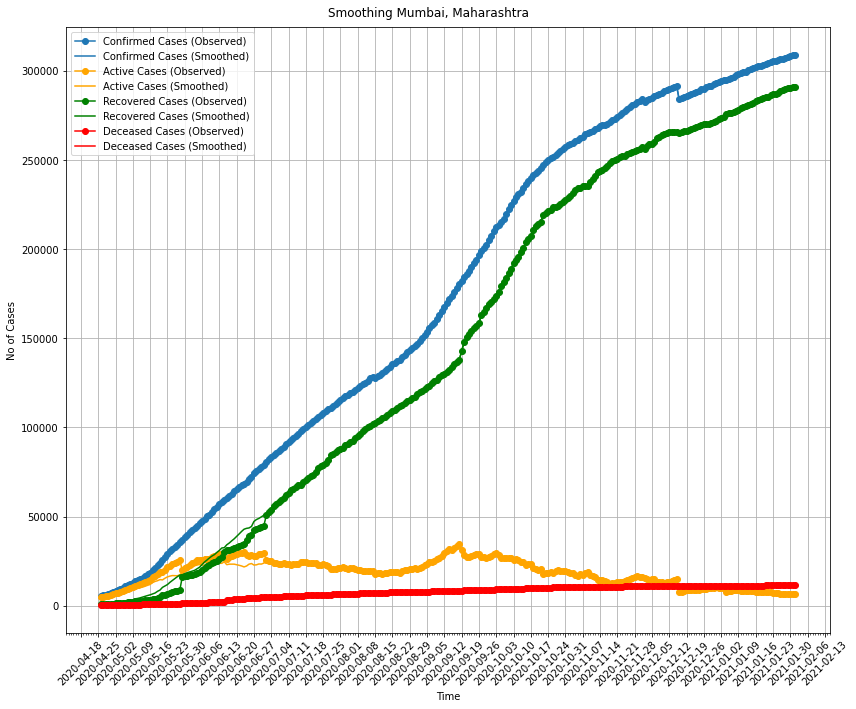

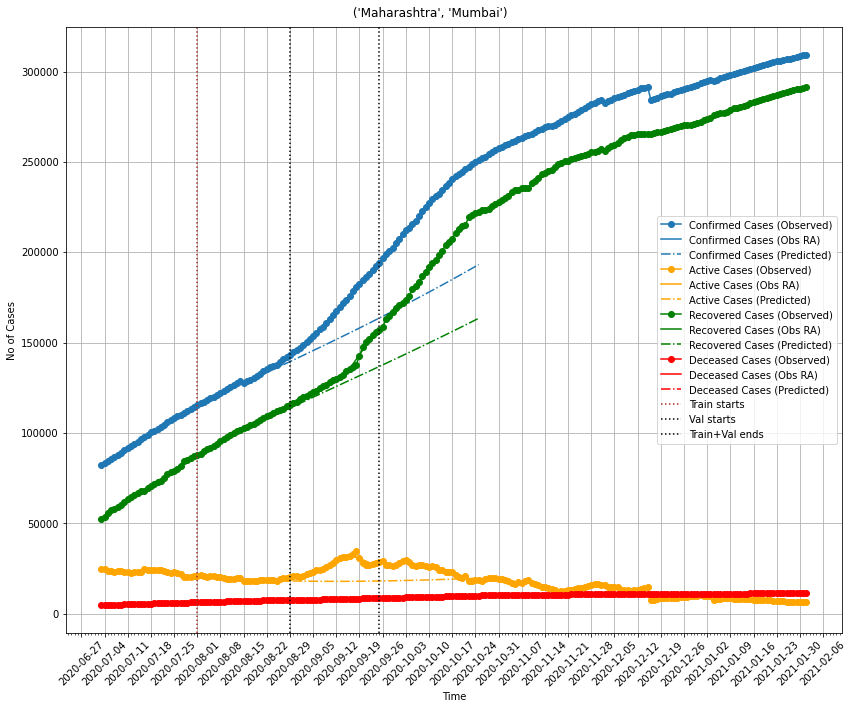

In [5]:
predictions_dict = single_fitting_cycle(**copy.deepcopy(config['fitting']))

## Loss Dataframe

{}

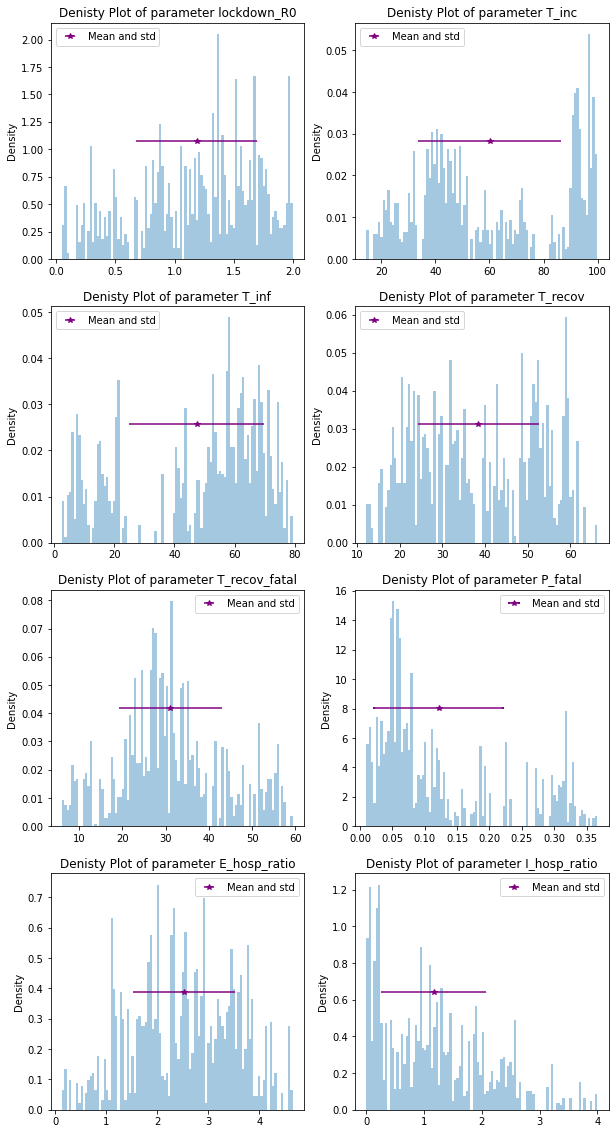

In [6]:
from viz.fit import plot_histogram
fig,axs = plt.subplots(4,2,figsize = (10,20))
plot_histogram(predictions_dict,fig = fig,axs=axs)

In [7]:
predictions_dict['df_loss']

,train,val,test
total,0.890632,9.030178,20.779441
active,2.727324,30.659731,24.373482
recovered,0.991908,5.000974,21.023994
deceased,1.66436,0.558694,0.658918


## Plot Best Forecast

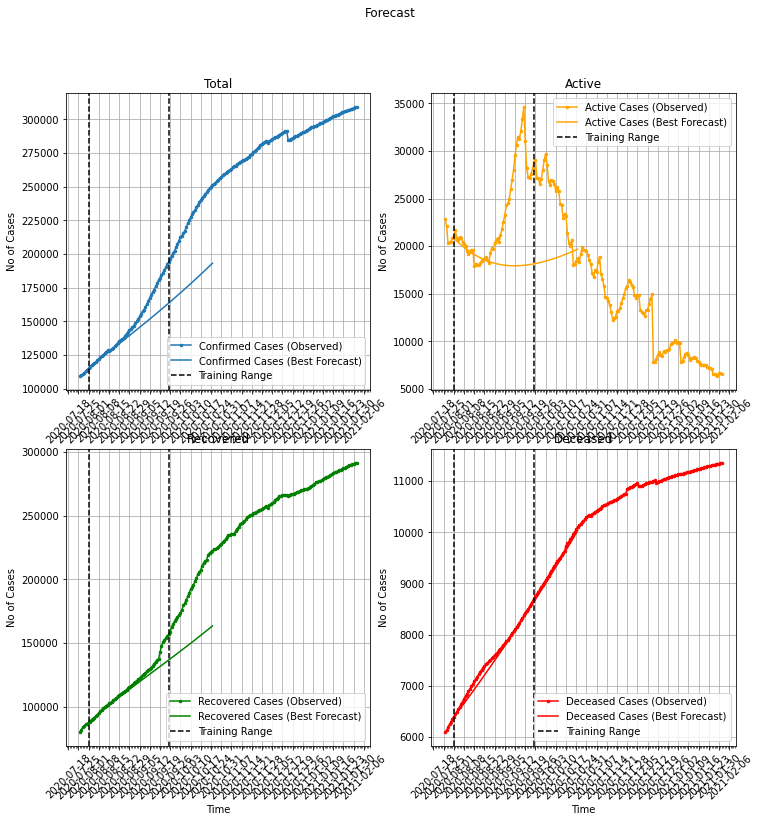

In [8]:
predictions_dict['forecasts'] = {}
predictions_dict['forecasts']['best'] = predictions_dict['trials']['predictions'][0]

predictions_dict['plots']['forecast_best'] = plot_forecast(predictions_dict, 
                                                            which_compartments=config['fitting']['loss']['loss_compartments'],
                                                            error_bars=False, **config['plotting'])

## Process trials + Find best beta

In [9]:
config['fitting'].keys()

dict_keys(['data', 'model_family', 'model', 'variable_param_ranges', 'default_params', 'optimiser', 'optimiser_params', 'split', 'loss', 'forecast'])

In [10]:
config['uncertainty']['uncertainty_params'].keys()

dict_keys(['fit_beta', 'fitting_method', 'fitting_method_params', 'variable_param_ranges', 'construct_percentiles_day_wise', 'date_of_sorting_trials', 'sort_trials_by_column', 'loss', 'percentiles'])

In [12]:
predictions_dict.keys()

dict_keys(['default_params', 'df_prediction', 'df_district', 'df_train', 'df_val', 'df_loss', 'trials', 'data_last_date', 'fitting_date', 'plots', 'smoothing_description', 'df_district_unsmoothed', 'run_params', 'forecasts'])

In [11]:
uncertainty_args = {'predictions_dict': predictions_dict,  "variable_param_ranges" :config['fitting']['variable_param_ranges'],
                     **config['uncertainty']['uncertainty_params']}
uncertainty = config['uncertainty']['method'](**uncertainty_args)

UnboundLocalError: local variable 'df_test' referenced before assignment

In [ ]:
predictions_dict['plots']['beta_loss'], _ = plot_beta_loss(uncertainty.dict_of_trials)

In [ ]:
uncertainty_forecasts = uncertainty.get_forecasts()
for key in uncertainty_forecasts.keys():
    predictions_dict['forecasts'][key] = uncertainty_forecasts[key]['df_prediction']
    
predictions_dict['forecasts']['ensemble_mean'] = uncertainty.ensemble_mean_forecast

## Plot Top k Trials

In [ ]:
kforecasts = plot_top_k_trials(predictions_dict, k=config['plotting']['num_trials_to_plot'],
                               which_compartments=config['plotting']['plot_topk_trials_for_columns'])
                               
predictions_dict['plots']['forecasts_topk'] = {}
for column in config['plotting']['plot_topk_trials_for_columns']:
    predictions_dict['plots']['forecasts_topk'][column.name] = kforecasts[column]

In [ ]:
predictions_dict['beta'] = uncertainty.beta
predictions_dict['beta_loss'] = uncertainty.beta_loss
predictions_dict['deciles'] = uncertainty_forecasts

## Plot Deciles Forecasts

In [ ]:
for fits_to_plot in config['plotting']['pair_fits_to_plot']:
    predictions_dict['plots'][f'forecast_{fits_to_plot[0]}_{fits_to_plot[1]}'] = plot_forecast(
        predictions_dict, which_compartments=config['fitting']['loss']['loss_compartments'],
        fits_to_plot=fits_to_plot, **config['plotting'])

In [ ]:
ptiles_plots = plot_ptiles(predictions_dict, which_compartments=config['plotting']['plot_ptiles_for_columns'])
predictions_dict['plots']['forecasts_ptiles'] = {}
for column in config['plotting']['plot_ptiles_for_columns']:
    predictions_dict['plots']['forecasts_ptiles'][column.name] = ptiles_plots[column]

## Create Report

In [ ]:
save_dict_and_create_report(predictions_dict, config, ROOT_DIR=output_folder, config_filename=config_filename)

## Create Output CSV

In [ ]:
df_output = create_decile_csv_new(predictions_dict)
df_output.to_csv(f'{output_folder}/deciles.csv')

## Create All Trials Output

In [ ]:
df_all = create_all_trials_csv(predictions_dict)
df_all.to_csv(f'{output_folder}/all_trials.csv')

## Log on W&B

In [ ]:
wandb.init(project="covid-modelling", config=wandb_config)

In [ ]:
log_wandb(predictions_dict)

## Log on MLFlow

In [ ]:
log_mlflow(config['logging']['experiment_name'], run_name=config['logging']['run_name'], artifact_dir=output_folder)